In [125]:
import umap
import numpy as np
import scipy as sp
import networkx as nx
from node2vec import Node2Vec
from pprint import pprint as pprint
import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import seaborn
import mplcursors
import pickle
import os
import collections
import codecs
from gensim.models import KeyedVectors
import pandas as pd
import scipy.spatial.distance as distance
%matplotlib nbagg

In [126]:
# Add nodes to the graph

G = nx.Graph()

with open('graph.desc', 'r') as fh:
    for line_number, line in enumerate(fh):
        if line_number >= 2:
            article_name = line.split("\t")[1][1:][:-2]
            line_number = int(line.split("\t")[0])
            G.add_node(line_number, article_name=article_name)

In [127]:
# Add edges to the graph

with open('graph.graph', 'r') as fh:
    for line_number, edge in enumerate(fh):
        src = (edge.split("\t")[0]).split(" ")[0].rstrip()
        dest = (edge.split("\t")[0]).split(" ")[1].rstrip()
        G.add_edge(src,dest)

In [128]:
pprint(nx.info(G))

('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 459513\n'
 'Number of edges: 678216\n'
 'Average degree:   2.9519')


In [129]:
# Get only nodes with degree >= min_degree
min_degree = 20
nodes = [node for node, degree in G.degree() if degree >= min_degree]

In [130]:
# Create a subgraph of G (a new graph with nodes taken from G where degree >= min_degree)
subgraph_G = G.subgraph(nodes)

In [131]:
pprint(nx.info(subgraph_G))

('Name: \n'
 'Type: SubGraph\n'
 'Number of nodes: 11979\n'
 'Number of edges: 104490\n'
 'Average degree:  17.4455')


In [132]:
# List 10 nodes of the subgraph
list(subgraph_G.nodes(data=True))[:10]

[('87183', {}),
 ('215294', {}),
 ('39193', {}),
 ('64921', {}),
 ('108633', {}),
 ('146596', {}),
 ('248719', {}),
 ('241986', {}),
 ('199365', {}),
 ('192180', {})]

In [133]:
# Dictionary of attributes (article name) keyed by node (article ID)
article_name = nx.get_node_attributes(G, name='article_name')

# Print example
article_name[251890]

'Soul music'

In [134]:
# Extract largest common component

# Get a list of all connected components
connected_components = nx.connected_components(subgraph_G)
# Get a largest connected component
largest_cc_nodes = max(connected_components, key=len)
# Create a subgraph of subgraph_G (a new connected graph)
largest_cc_graph = subgraph_G.subgraph(largest_cc_nodes)
# Check if it's connected
nx.is_connected(largest_cc_graph)

True

In [135]:
pprint(nx.info(largest_cc_graph))

('Name: \n'
 'Type: SubGraph\n'
 'Number of nodes: 11779\n'
 'Number of edges: 104470\n'
 'Average degree:  17.7383')


In [136]:
# Save a new subgraph to file

with open('graph-largest-common-cc.graph', 'w') as f:
    for edge in largest_cc_graph.edges:
        src = edge[0]
        dest = edge[1]
        f.write(src + ' ' + dest + '\n')

In [137]:
# Create a list of the largest_cc_graph nodes

id_node = []

for node in largest_cc_graph.nodes:
    id_node.append((int)(node))

In [138]:
# node_id = {}
# index = 0

# for node in largest_cc_graph.nodes:
#     node_id[(int)(node)] = index
#     index += 1


In [139]:
# Get a dictionary of nodes with betweenness centrality as the value
largest_cc_graph_betweenness = nx.betweenness_centrality(largest_cc_graph, k=500)

In [140]:
# Print betweenness of 10 nodes
print({k: largest_cc_graph_betweenness[k] for k in list(largest_cc_graph_betweenness)[:10]})

{'87183': 8.480820928050793e-06, '215294': 1.294212956742448e-05, '39193': 1.1418331734102215e-05, '64921': 6.843100158518956e-05, '108633': 0.00012940852272948482, '146596': 6.631433287863994e-07, '248719': 1.4880602549284873e-05, '241986': 2.8802551534043398e-05, '199365': 7.696550020218033e-05, '223570': 2.9906793834537145e-05}


In [141]:
with open("graph-largest-cc-betweenness-500.desc", "w") as file:
    for node in largest_cc_graph_betweenness:
        file.write(str(node) + ' ' + str(largest_cc_graph_betweenness[node]) + ' "'+article_name[int(node)]+'"\n')

<IPython.core.display.Javascript object>


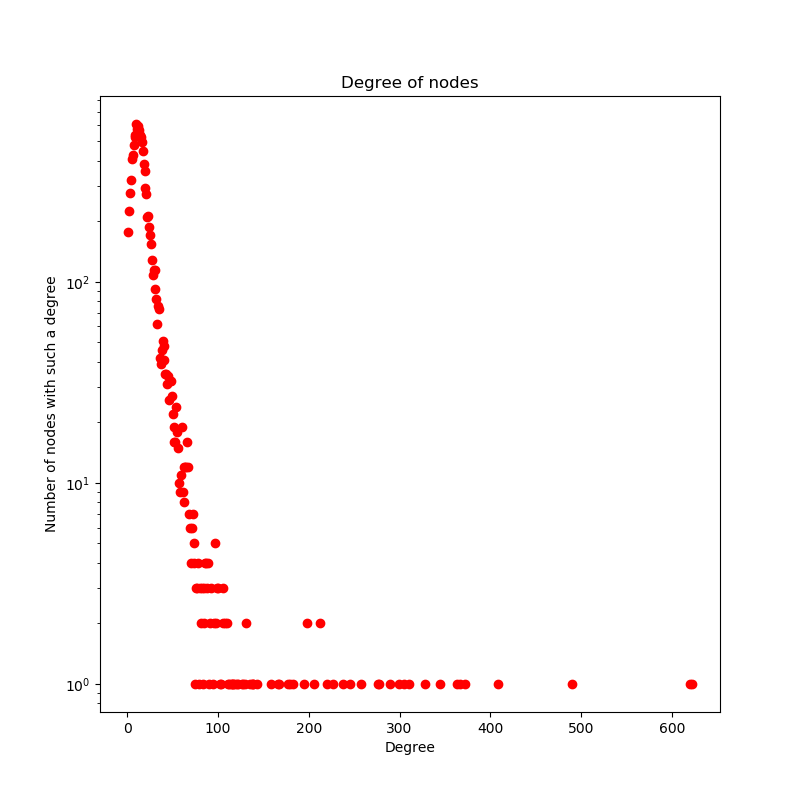

In [142]:
# Draw a chart: Degree of nodes

degrees = [largest_cc_graph.degree(node) for node in largest_cc_graph]
degrees_frequency = {x:degrees.count(x) for x in degrees}

plt.figure(figsize=(8, 8))
plt.title('Degree of nodes')
plt.xlabel('Degree')
plt.ylabel('Number of nodes with such a degree')
plt.yscale('log')
plt.plot(degrees_frequency.keys(), degrees_frequency.values(), 'ro')
plt.show()

In [143]:
nodes_count = len(largest_cc_graph.nodes)

# Precompute probabilities and generate walks

files = os.listdir(".")

if "node2vec.pickle" in files:
    with open("node2vec.pickle", "rb") as file:
        node2vec = pickle.load(file)
else:
    node2vec = Node2Vec(largest_cc_graph, dimensions=32, walk_length=50, num_walks=250, p=1, q=1, 
                 workers=4, sampling_strategy=None)

Computing transition probabilities:   9%|▉         | 1059/11779 [00:09<01:40, 106.20it/s]/Users/anna/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Generating walks (CPU: 2): 100%|██████████| 63/63 [50:09<00:00, 47.79s/it]





In [144]:
# if "node2vec.pickle" not in files:
#     with open("node2vec.pickle", "wb") as file:
#         pickle.dump(node2vec, file)

In [145]:
# Embed
# Any keywords acceptable by gensim.Word2Vec can be passed,
# `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

model = node2vec.fit(size=32, window=10, min_count=1, batch_words=8)

print(model)

Word2Vec(vocab=11779, size=32, alpha=0.025)


In [146]:
if "wv.txt" not in files:
    wv = model.wv
    wv.save('wv.txt')
else:
    wv = KeyedVectors.load('wv.txt')

In [147]:
# Print similar nodes

for node in wv.similar_by_vector(model['251899'])[:4]:
    index = int(node[0])
    print(article_name[index])

print('\n')

for node in wv.most_similar('251899')[:4]:
    index = int(node[0])
    print(article_name[index])
    
print('\n')

for node in wv.similar_by_vector(wv.vectors[0])[:4]:
    index = int(node[0])
    print(article_name[index])
    
print('\n')
    
index = np.where(model.wv.vectors==model['251899'])

print(index)


Contemporary R&B
Slow jam
Luke James
Urban contemporary


Slow jam
Luke James
Urban contemporary
Babyface (musician)


Contemporary R&B
Slow jam
Luke James
Urban contemporary


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]))


/Users/anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [148]:
# Create a sorted list that represents an order of vectors in model.wv.vectors

id_name = []

for node in largest_cc_nodes:
    index = np.where(wv.vectors==model[str(node)])[0][0]
    id_name.insert(index, node)
    
print(id_name[:10])

/Users/anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


['251899', '87183', '36497', '122206', '251890', '215294', '39193', '55120', '64921', '68725']


In [149]:
with open("id-name.txt", "w") as file:
    for idn in id_name:
        file.write(idn+',')

In [150]:
# Example 'nodes substraction'

for node in wv.most_similar(positive=['228840'], negative=['246320'])[:5]:
    index = int(node[0])
    print(article_name[index])

Yoshio Sakamoto
First Epistle of Peter
Touch! Generations
Brain Age: Train Your Brain in Minutes a Day!
Josephus on Jesus


In [151]:
# UMAP

umap_obj = umap.UMAP(n_neighbors=10, min_dist=0.05, n_components=3)
transformed = umap_obj.fit_transform(wv.vectors)

print(transformed[:10])

[[ 2.12825474 -2.64209097  4.16242082]
 [-0.26492689 -2.08496944  6.24016776]
 [-0.44805624 -4.30032614 -6.46223768]
 [-0.14166149 -1.99844864  6.10255158]
 [ 1.27457182 -5.57880242 -5.20110676]
 [-0.46542497 -4.27113672 -6.44181945]
 [-0.32213123 -3.58191604 -6.73475671]
 [-6.59590914  1.39582867 -0.2857624 ]
 [ 1.07556104 -0.31795333 -1.68767708]
 [ 2.31325305 -2.18384651  2.34996781]]


In [152]:
i = 0

with open("vectors-umap-10-0_05-3-with-betweenness.txt", "w") as file:
    file.write("x,y,z,name,id,betweenness\n")
    for v in transformed:                  
        file.write(str(v[0])+","+str(v[1])+","+str(v[2])+","+article_name[int(id_name[i])]+","+id_name[i]+","+str(largest_cc_graph_betweenness[id_name[i]])+"\n")
        i += 1

In [153]:
# Returns a number of remaining nearest neighbors (before UMAP vs after UMAP)

def similarities(node, n):
    node_name = article_name[node]
    
    node_line_id = id_name.index(str(node))
   
    before_umap_neighbors = []
    umap_neighbors = []

    # Before UMAP
    # print('Before UMAP - ', article_name[node],':\n')

    for node in wv.most_similar(str(node), topn = n):
        index = int(node[0])
        # print(article_name[index])
        before_umap_neighbors.append(article_name[index])
    
    # After UMAP
    dst_all = []

    for i in range (0,len(transformed)):
        dst = distance.euclidean(transformed[node_line_id],transformed[i])
        dst_all.append(dst)

    arr = np.array(dst_all)    
    res = np.argsort(arr)[1:n]

    # print('\nUMAP - ', node_name,':\n')
    
    for r in res:
        # print(article_name[int(id_name[r])])
        umap_neighbors.append(article_name[int(id_name[r])])
        
    intersection = len(list(set(umap_neighbors).intersection(before_umap_neighbors)))   
    
    to_file_content = str(node_name) + ',' + str(intersection) + '\n'
    return to_file_content

In [154]:
# Example
similarities(251899, 20)

'Contemporary R&B,0\n'

In [155]:
with open('neighbours.txt', 'a') as file:
    for node in tqdm.tqdm(largest_cc_nodes):   
        value_to_write_to_file = similarities(int(node), 20)
        file.write(value_to_write_to_file)
        file.flush()

  0%|          | 49/11779 [00:09<39:27,  4.96it/s]/Users/anna/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 11779/11779 [37:29<00:00,  5.24it/s]


In [156]:
df = pd.read_csv("neighbours.txt", names=['link', '#remaining_neighbours'])
df.describe()

,#remaining_neighbours
count,11779.000000
mean,0.035911
std,0.192359
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000


In [157]:
def interactive_umap(n_neighbors, min_dist, n_components):
    umap_obj = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    transformed = umap_obj.fit_transform(wv.vectors)
    
    i = 0
    with open("vectors-umap-"+str(n_neighbors)+"-"+str(min_dist)+".txt", "w") as file:
        file.write("x,y,z,name,id,betweenness\n")
        for v in transformed:                  
            file.write(str(v[0])+","+str(v[1])+","+str(v[2])+","+id_name[i]+","+article_name[int(id_name[i])]+","+str(largest_cc_graph_betweenness[str(id_node[i])])+"\n")
            i += 1
                        
    plt.figure(figsize=(7.5,7.5))
    seaborn.regplot(x=transformed[:, 0], y=transformed[:, 1], fit_reg=False)    
    
    plt.show()

In [161]:
interactive(interactive_umap, n_neighbors=10, min_dist=0.05, n_components=3, metric='correlation')

interactive(children=(IntSlider(value=10, description='n_neighbors', max=30, min=-10), FloatSlider(value=0.05, description='min_dist', max=0.15000000000000002, min=-0.05), IntSlider(value=3, description='n_components', max=9, min=-3), Output()), _dom_classes=('widget-interact',))